In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import theano.tensor as tt
from theano import shared



In [2]:
# read in data now
process = pd.read_csv("data/process.csv")
customer = pd.read_csv("data/customer.csv")
amount = pd.read_csv("data/amount.csv")

In [3]:
# transform data

ind = amount["custID"]
t = amount["t"]
z = amount["amount"]

logz = np.log(z)
logt = np.log(t)

process = process[["n","tx","T"]]
XX = customer[["google","online","research","lateperiod"]]
XX["intercept"] = 1

p = 3
k = XX.shape[1]
n = XX.shape[0]
nn = len(z)


In [6]:
# create custom function

def loglik(process, theta):
    mu = np.exp(theta[:,0])
    lbd = np.exp(theta[:,1])
    
    x = process[:,0]-1
    tx = process[:,1]
    T = process[:,2]
    
    tmp1 = mu * np.exp(-(lbd+mu) * tx)
    tmp2 = lbd * np.exp(-(lbd+mu) * T)
    prob = x * np.log(lbd) - np.log(lbd+mu) + np.log(tmp1 + tmp2)
    
    return prob.sum()
                       

In [7]:
# create the model
model = pm.Model()
with pm.Model() as model:
    beta = pm.Normal("beta", mu=0, sd=2)
    sigma2 = pm.HalfCauchy("sigma2", beta=5)
    mu = np.zeros((k,p))
    mu[4,0] = -4.0
    mu[4,1] = -4.0
    mu[4,2] = 4.0
    B = pm.MvNormal("B", mu=mu, cov=2.0*np.eye(p), shape=(k,p))    
    packed_L = pm.LKJCholeskyCov('packed_L', n=p,
                                 eta=2., sd_dist=pm.HalfCauchy.dist(2.5))
    L = pm.expand_packed_triangular(p, packed_L)
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))
    
    #Sigma = pm.Wishart('Sigma', nu=4, V = 10*np.eye(p))
    #Sigma = np.linalg.inv(Sigma)
    
    theta = pm.MvNormal('theta', mu=tt.dot(XX,B), cov=Sigma, shape=(n,p))
    #theta = pm.MvNormal('theta', mu=np.zeros((n,p)), cov=Sigma, shape=(n,p))
    
    obs = pm.DensityDist('loglik', loglik, observed={'process': process, 'theta':theta})
    bb = theta[[ind-1],2]
    mu_z = bb + beta * logt
    z_obs = pm.Normal('z_obs', mu=mu_z, sd=sigma2, shape=nn,observed=logz)
    

In [11]:
with model:
    trace = pm.sample(draws=2000, n_init=100)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2500/2500 [02:59<00:00, 15.32it/s]/Users/chunhua/anaconda/lib/python3.5/site-packages/pymc3/step_methods/hmc/nuts.py:467: UserWarning: Chain 0 contains 88 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12d4bd0f0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12a9ab5f8>]], dtype=object)

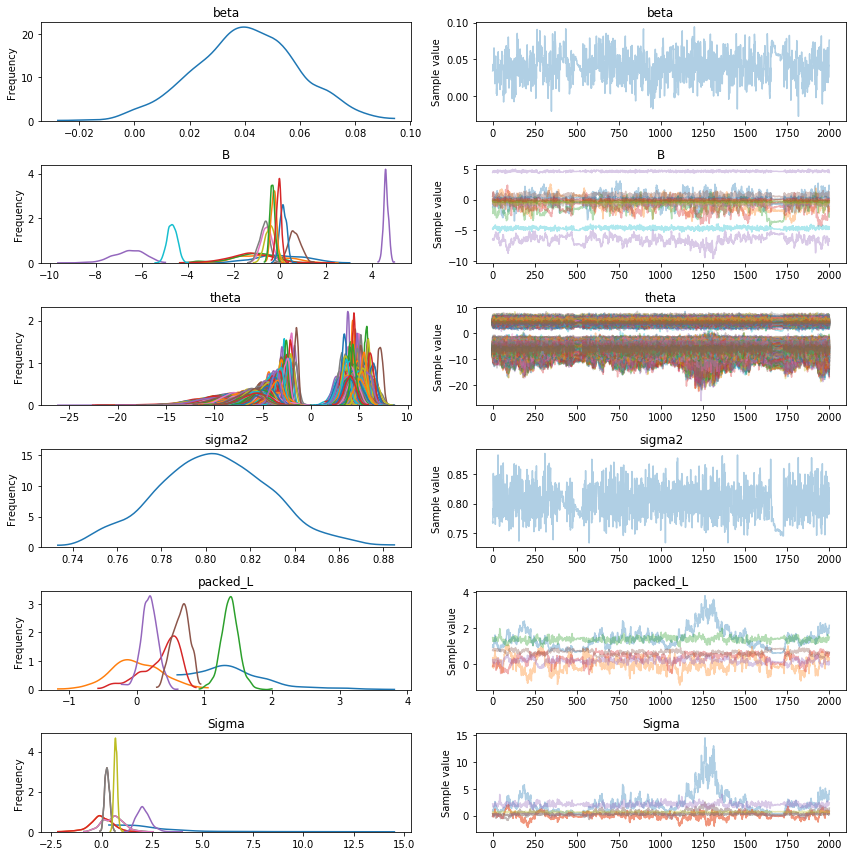

In [12]:
pm.traceplot(trace)

In [ ]:
trace

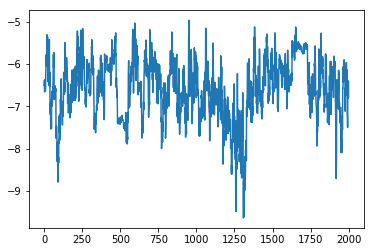

In [13]:
plt.plot(trace.B[:,4,0])

In [14]:
pm.summary(trace)


beta:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.040            0.019            0.001            [0.003, 0.075]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.003          0.028          0.040          0.053          0.076


B:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  ..............................[0, :]...............................
  0.035            1.098            0.087            [-2.041, 2.083]
  0.640            0.277            0.010            [0.163, 1.245]
  0.144            0.147            0.005            [-0.126, 0.435]
  ..............................[1, :]...............................
  -0.784           1.074            0.091            [-2.793, 1

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  ..............................[0, :]...............................
  2.353            1.960            0.186            [0.360, 6.486]
  -0.010           0.566            0.046            [-1.302, 1.032]
  0.569            0.516            0.048            [-0.442, 1.580]
  ..............................[1, :]...............................
  -0.010           0.566            0.046            [-1.302, 1.032]
  2.068            0.339            0.019            [1.451, 2.754]
  0.273            0.118            0.007            [0.048, 0.502]
  ..............................[2, :]...............................
  0.569            0.516            0.048            [-0.442, 1.580]
  0.273            0.118            0.007            [0.048, 0.502]
  0.697            0.084            0.003            [0.528, 0.854]

  Posterior quantiles:
  2.5     